In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import time

In [2]:
def parse_attack_types(filename):
    """
    Generate a mapping that looks like:

    {
        'teardrop': {
            'encoding': 0,
            'category': 'dos'
        },
        'smurf': {
            'encoding': 1,
            'category': 'dos'
        },
        ...
    }

    The 'encoding' becomes important in some learning algorithms. We have to encode text
    into numbers so some algorithms can process them.
    """
    attack_map = {}
    attack_encoding = {}
    count = 0
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        attack, category = line.split()
        if attack not in attack_map:
            attack_map[attack] = {
                'encoding': count,
                'category': category
            }
            count += 1
    return attack_map


def encode_data(train_data, cols):
    """
    Encode any strings in the training data so that they are integers.
    Also return the map of encodings.
    """
    
    """ Fulbert -- Change the funciton a bit, so cols is a parameter """
    encodings = {}
    for col in cols:
        unique_values = train_data[col].unique()
        mapping = {}
        reverse_mapping = {}  # Used for lookup later if we need it
        for j, value in enumerate(unique_values):
            mapping[value] = j
            reverse_mapping[j] = value
        # Encode strings like ('tcp', 'udp', 'icmp') into (0, 1, 2)
        train_data[col] = train_data[col].map(mapping)
        encodings[col] = reverse_mapping
    return encodings


def parse_data(filename):
    return pd.read_csv(filename, header=None)

Running project
Attack mapping:
{'back': {'encoding': 0, 'category': 'dos'}, 'buffer_overflow': {'encoding': 1, 'category': 'u2r'}, 'ftp_write': {'encoding': 2, 'category': 'r2l'}, 'guess_passwd': {'encoding': 3, 'category': 'r2l'}, 'imap': {'encoding': 4, 'category': 'r2l'}, 'ipsweep': {'encoding': 5, 'category': 'probe'}, 'land': {'encoding': 6, 'category': 'dos'}, 'loadmodule': {'encoding': 7, 'category': 'u2r'}, 'multihop': {'encoding': 8, 'category': 'r2l'}, 'neptune': {'encoding': 9, 'category': 'dos'}, 'nmap': {'encoding': 10, 'category': 'probe'}, 'perl': {'encoding': 11, 'category': 'u2r'}, 'phf': {'encoding': 12, 'category': 'r2l'}, 'pod': {'encoding': 13, 'category': 'dos'}, 'portsweep': {'encoding': 14, 'category': 'probe'}, 'rootkit': {'encoding': 15, 'category': 'u2r'}, 'satan': {'encoding': 16, 'category': 'probe'}, 'smurf': {'encoding': 17, 'category': 'dos'}, 'spy': {'encoding': 18, 'category': 'r2l'}, 'teardrop': {'encoding': 19, 'category': 'dos'}, 'warezclient': {'e

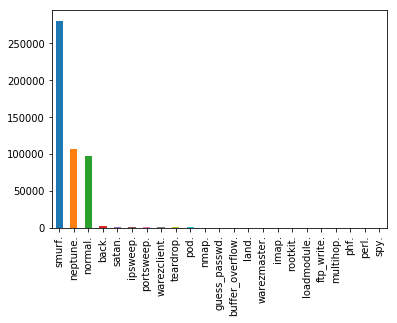

In [3]:
print('Running project')
attack_map = parse_attack_types('./dataset/attack_types.txt')
print('Attack mapping:')
print(attack_map)
train_data = parse_data('./dataset/kddcup.data_10_percent')
print('Raw data:')
print(train_data[:2])
## See labeled data distribution
train_data[41].value_counts().plot(kind='bar')
encodings = encode_data(train_data, (1, 2, 3, 41))
print('Encoded data:')
print(train_data[:2])
print('Encodings:')
print(encodings)

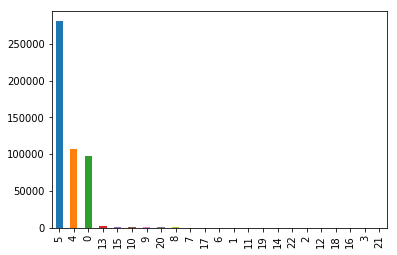

In [4]:
train_data[41].value_counts().plot(kind='bar')

In [5]:
'''Describe Data using Panda Describe''' 
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
count,494021.000000,494021.000000,494021.000000,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,1.189338,8.392376,0.835960,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,...,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412,3.932560
std,707.746472,0.960704,4.973796,1.579212,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,...,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140,2.297779
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,2.000000,9.000000,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,0.000000,2.000000,10.000000,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,58329.000000,2.000000,65.000000,10.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,22.000000


In [6]:
'''Display Correlation Matrix, 
the column we are interested is column 41 which is the label '''  
train_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,-0.023715,0.027185,-0.006068,0.004258,0.005440,-0.000452,-0.003235,0.003786,0.013213,...,-0.117515,-0.118458,0.406233,0.042642,-0.006983,-0.030400,-0.030612,0.006739,0.010465,-0.077988
1,-0.023715,1.000000,0.167669,-0.655333,-0.002664,-0.032433,-0.008262,-0.005357,-0.003183,-0.054640,...,0.711421,0.692295,-0.260154,0.956481,-0.117590,-0.574551,-0.573439,-0.309225,-0.308833,0.493821
2,0.027185,0.167669,1.000000,0.349884,-0.001548,-0.025936,-0.008394,0.023455,0.002456,-0.034878,...,-0.356139,-0.389429,0.127603,0.127539,-0.173734,0.334510,0.334999,0.059593,0.061795,0.409210
3,-0.006068,-0.655333,0.349884,1.000000,0.003872,-0.013470,0.013371,-0.025261,-0.001361,-0.021159,...,-0.859183,-0.879532,0.256300,-0.635473,-0.029200,0.928322,0.928893,0.210140,0.211055,0.038441
4,0.004258,-0.002664,-0.001548,0.003872,1.000000,-0.000002,-0.000020,-0.000139,-0.000005,0.004483,...,-0.003212,-0.002052,0.000578,-0.000724,0.001186,-0.000718,0.001122,-0.000393,0.001328,0.008340
5,0.005440,-0.032433,-0.025936,-0.013470,-0.000002,1.000000,-0.000175,-0.001254,0.016288,0.004365,...,-0.005850,0.007058,-0.005314,-0.020143,0.008707,-0.011334,-0.011235,-0.005000,-0.005471,0.002452
6,-0.000452,-0.008262,-0.008394,0.013371,-0.000020,-0.000175,1.000000,-0.000318,-0.000017,-0.000295,...,-0.011587,0.001984,-0.000333,0.003799,0.083320,0.012658,0.007795,-0.001511,-0.001665,0.019074
7,-0.003235,-0.005357,0.023455,-0.025261,-0.000139,-0.001254,-0.000318,1.000000,-0.000123,-0.002106,...,-0.058624,-0.054903,0.071857,-0.031803,0.012092,-0.019091,-0.022104,0.029774,-0.011904,0.082780
8,0.003786,-0.003183,0.002456,-0.001361,-0.000005,0.016288,-0.000017,-0.000123,1.000000,0.000356,...,-0.004540,-0.003279,0.010536,-0.002002,-0.000408,-0.001194,-0.001191,-0.000648,-0.000641,0.004872
9,0.013213,-0.054640,-0.034878,-0.021159,0.004483,0.004365,-0.000295,-0.002106,0.000356,1.000000,...,-0.038730,-0.029117,0.001319,-0.052923,-0.004467,-0.019491,-0.020201,-0.006541,-0.007749,0.174389


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC0AEAED68>]],
      dtype=object)

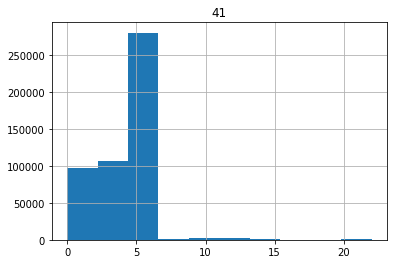

In [7]:
train_data.hist(column=41)

In [8]:
"""Try different attack mapping
        normal = 0  
        dos = 1
        r2l = 2 
        u2r = 3 
        probe = 4 
        
        We will end up with 5 classes instead of 23 classes
        
        One thing to note when mapping the 5 classes, there is a period at the end of the 
        label on the original file!!! Don't forget about that. 
"""
train_data_2 = parse_data('./dataset/kddcup.data.corrected')
train_data_2.head()
encodings = encode_data(train_data_2, (1, 2, 3))

In [9]:
def revised_attack_mapping(attack_map):
    revised_attack_map = {}
    for name, value in attack_map.items():
        revised_attack_map[name + "."] = (value['category']) #Don't forget about the period at the end!!
    return revised_attack_map

def attack_category_encoding():
    """
        normal = 0  
        dos = 1
        r2l = 2 
        u2r = 3 
        probe = 4 
    """    
    attack_category_map = {}
    attack_category_map ['normal'] = 0
    attack_category_map ['dos'] = 1
    attack_category_map ['r2l'] = 2
    attack_category_map ['u2r'] = 3
    attack_category_map ['probe'] = 4
    return attack_category_map

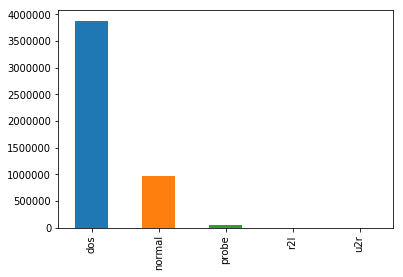

In [10]:
category_attack_map = revised_attack_mapping(attack_map)
category_attack_map['normal.'] = "normal" #Removing the period at the end!!
train_data_2[41] = train_data_2[41].map(category_attack_map)
train_data_2[41].value_counts().plot(kind='bar')

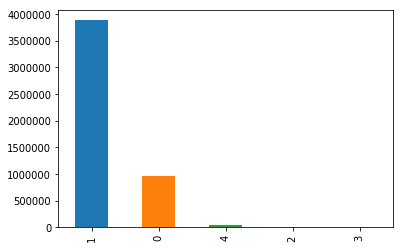

In [11]:
train_data_2[41] = train_data_2[41].map(attack_category_encoding())
train_data_2[41].value_counts().plot(kind='bar')

In [12]:
X = train_data_2.drop(columns=[41])
y = train_data_2[[41]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

In [13]:
## Method to test sklearn classifier
def test_classifier(clf):
    start = time.time()
    clf = clf.fit(X_train, y_train)
    training_ends = time.time()
    prediction = clf.predict(X_test)
    prediction_ends = time.time()
    print (metrics.classification_report(y_test, prediction))
    print ("Accuracy Score: %s" % metrics.accuracy_score(y_test, prediction))
    print ("Classifier Training time = %s" % (training_ends - start))
    print ("Classifier Prediction time = %s" % (prediction_ends - training_ends))
    return clf


In [14]:
## Multinomial Naive Bayes Classifier
clf_MultinomialNB = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_MultinomialNB = test_classifier(clf_MultinomialNB)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.61      0.76    320433
          1       0.95      1.00      0.97   1282047
          2       0.01      0.20      0.02       374
          3       0.00      0.62      0.00        13
          4       0.00      0.00      0.00     13616

avg / total       0.95      0.91      0.92   1616483

Accuracy Score: 0.9136031742987708
Classifier Training time = 2.029104471206665
Classifier Prediction time = 0.5981762409210205


In [15]:
## Bernoulli Naive Bayes Classifier
clf_BernoulliNB = BernoulliNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_BernoulliNB = test_classifier(clf_BernoulliNB)

             precision    recall  f1-score   support

          0       0.98      0.89      0.94    320433
          1       0.99      0.94      0.96   1282047
          2       0.09      0.35      0.15       374
          3       0.08      0.54      0.14        13
          4       0.08      0.61      0.15     13616

avg / total       0.98      0.93      0.95   1616483

Accuracy Score: 0.9297926424218504
Classifier Training time = 8.84793472290039
Classifier Prediction time = 1.9096009731292725


In [16]:
## Linear SVC Classifier
#clf_LinearSVC = LinearSVC(random_state=0, tol=1e-5)
#clf_LinearSVC = test_classifier(clf_LinearSVC)

In [20]:
## Decision Tree Classifier
clf_DecisionTree = DecisionTreeClassifier(max_depth=30)
clf_LinearSVC = test_classifier(clf_DecisionTree)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    320433
          1       1.00      1.00      1.00   1282047
          2       0.93      0.94      0.94       374
          3       0.50      0.46      0.48        13
          4       1.00      1.00      1.00     13616

avg / total       1.00      1.00      1.00   1616483

Accuracy Score: 0.9999276206430875
Classifier Training time = 50.463581800460815
Classifier Prediction time = 0.7797129154205322
